In [28]:
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
import gzip
deep_hepg2 = {} # chrom -> position -> score
files = ['/mnt/dnase/hepg2_deeplift_20000.tsv.gz']
for fn in files:
    with gzip.open(fn) as fp:
        for line in fp:
            chrom, pos, score = line.strip().split()
            if chrom not in deep_hepg2:
                deep_hepg2[chrom] = {}
            deep_hepg2[chrom][int(pos)] = float(score)

In [7]:
encode = {}
with gzip.open('/mnt/matches.txt.gz') as regions:
    for i, line in enumerate(regions):
        motif, chrom, start, end, strand = line.strip().split()
        start, end = int(start), int(end)
        if chrom not in encode: encode[chrom] = {}
        if chrom not in deep_hepg2: continue
        for pos in range(start, end):
            if pos not in deep_hepg2[chrom]: continue
            if pos not in encode[chrom]: encode[chrom][pos] = set()
            encode[chrom][pos].add(motif)

In [54]:
# 3335 above threshold, 3332 are not on edge of interval.., 862 after require not overlapping motif...
# When I look at the intervals that this produces though there are overlaps with motifs? WHY?
# Was incorrectly requiring all sites to contain a motif :(
unexplained = []
for chrom, positions in deep_hepg2.items():
    for pos, score in positions.items():
        if chrom == 'chrY': continue
        if ((score > .2) and all(pos + i in deep_hepg2[chrom] for i in range(-10, 10))
            and all(pos + i not in encode[chrom] for i in range(-10, 10))):
            found = False
            for c, start, end in unexplained:
                if c == chrom and start < pos < end:
                    found = True
            if not found:
                unexplained += [(chrom, pos-10, pos + 10)]
len(unexplained)

841

In [53]:
out = open('unexplained4.bed', 'w')
for chrom, start, end in unexplained:
    assert end > start
    out.write(chrom.strip() + '\t' +  str(start) + '\t' + str(end) + '\n')

In [32]:
# Load in the data.
si_phi = {} # chrom, position, LOR (no entry implies not signiticant)
with gzip.open('../../data/conservation/hg19_29way_pi_lods_elements_12mers.chr_specific.fdr_0.1_with_scores.txt.gz') as conservation:
    for line in conservation:
        chrom, start, end, lor, branch = line.strip().split()
        start, end, lor = int(start), int(end), float(lor)
        if chrom not in deep_hepg2: continue
        if chrom not in si_phi: si_phi[chrom] = {}
        if (start not in deep_hepg2[chrom]
            and end not in deep_hepg2[chrom]): continue
        for pos in range(start, end):
            si_phi[chrom][pos] = lor

motif_1_fasta.txt


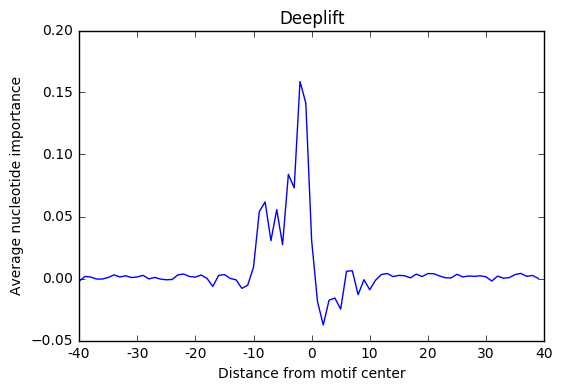

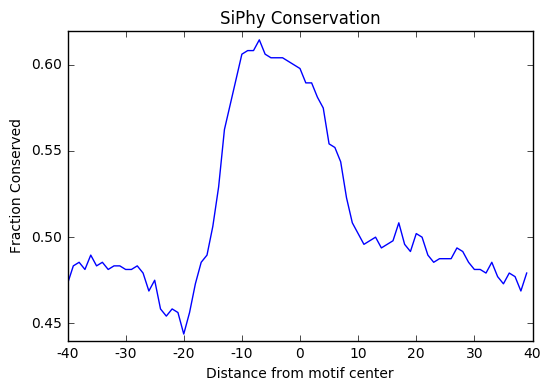

motif_2_fasta.txt


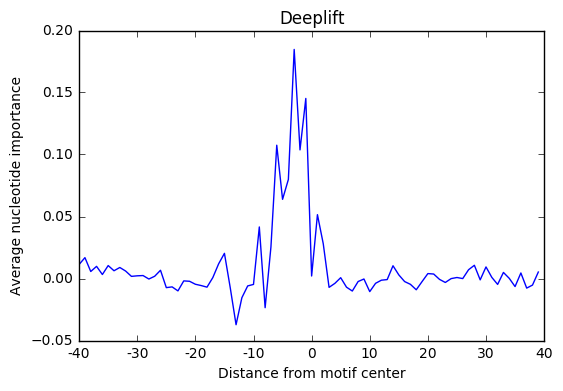

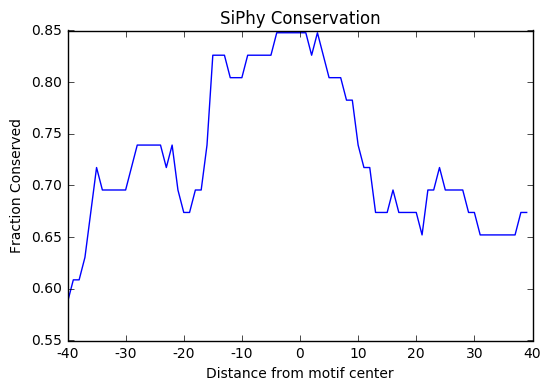

motif_4_fasta.txt


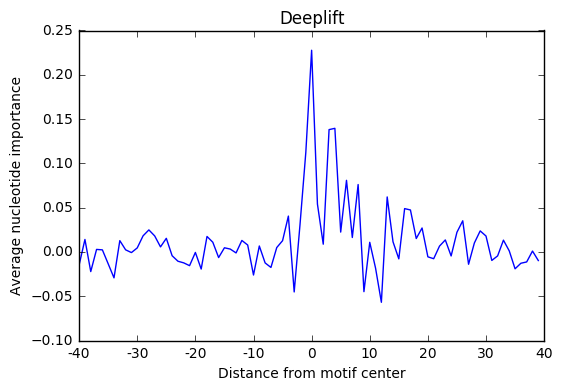

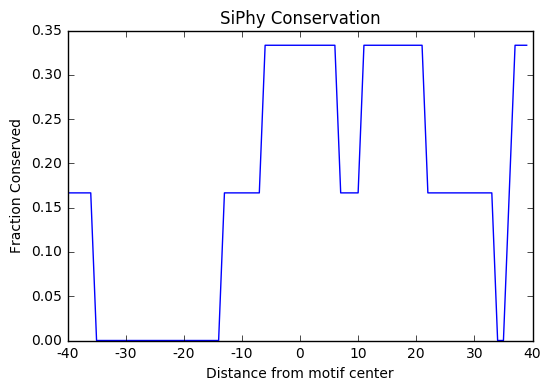

motif_3_fasta.txt


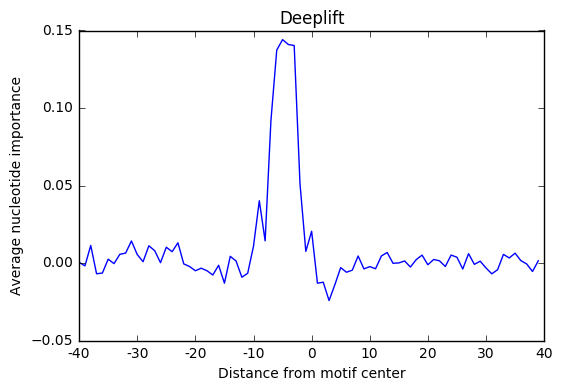

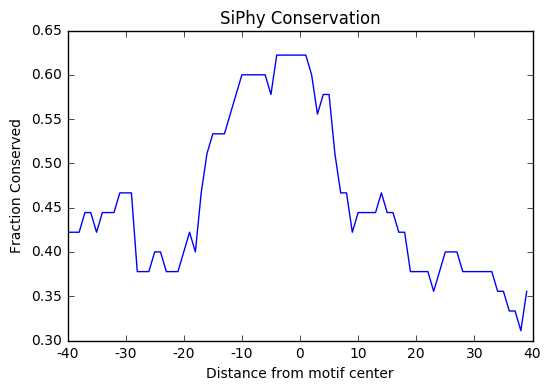

motif_5_fasta.txt


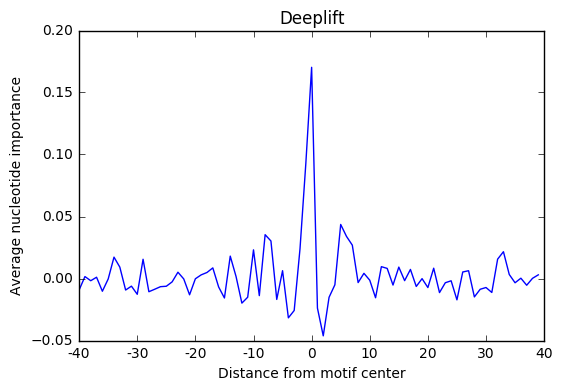

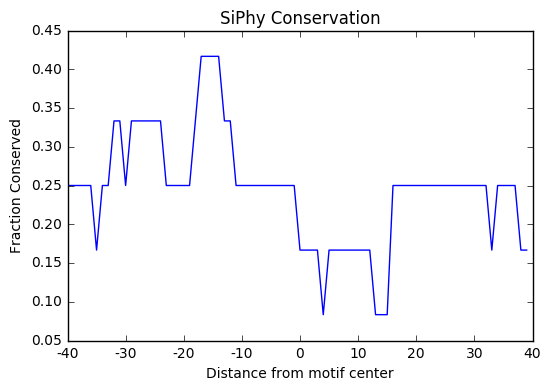

In [38]:
from glob import glob
import numpy as np
def conserve_motif(f):
    sites = open(f)
    counts = np.zeros((80,))
    num = 0
    for line in sites:
        if line[0] != '>': continue
        chrom, rest = line[1:].strip().split(':')
        start, rest = rest.split('-')
        end = rest.split('_')[0]
        offset = rest.split('=')[-1][1]
        
        center = (int(end) + int(start)) / 2 + int(offset)
        num += 1
        for pos in range(- 40, 40):
            counts[pos+40] += deep_hepg2[chrom][pos+center] if pos+center in deep_hepg2[chrom] else 0

    plt.plot(counts.T / num)
    plt.title('Deeplift')
    plt.xlabel('Distance from motif center')
    plt.ylabel('Average nucleotide importance')
    plt.xticks(range(0, 81, 10), range(-40, 41, 10))
    plt.show()

def deeplift_motif(f):
    sites = open(f)
    counts = np.zeros((80,))
    num = 0
    for line in sites:
        if line[0] != '>': continue
        chrom, rest = line[1:].strip().split(':')
        start, rest = rest.split('-')
        end = rest.split('_')[0]
        offset = rest.split('=')[-1][1]

        center = (int(end) + int(start)) / 2 + int(offset)
        num += 1
        for pos in range(- 40, 40):
            counts[pos+40] += pos+center in si_phi[chrom]
    
    plt.plot(counts.T / num)
    plt.title('SiPhy Conservation')
    plt.xlabel('Distance from motif center')
    plt.ylabel('Fraction Conserved')
    plt.xticks(range(0, 81, 10), range(-40, 41, 10))
    plt.show()
    
for fn in glob('motif*.txt'):
    print fn
    conserve_motif(fn)
    deeplift_motif(fn)